In [1]:
import cvtk
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import re
import pickle

from tqdm import tnrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [2]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [4]:
np.random.seed(0)

In [5]:
from cvtk.variant_files import VCFFile

#vcf = VCFFile('/gxfs_home/geomar/smomw504/cod/cod.500k.vcf')
vcf = VCFFile('/gxfs_work1/geomar/smomw426/cod_all_5_115/09_selectVariants/cod_all_5_115_filteredSNPs_gq20_dp8_ua_miss0.9_maf0.05_hwe001_bial.recode.vcf.gz')

reading file '/gxfs_work1/geomar/smomw426/cod_all_5_115/09_selectVariants/cod_all_5_115_filteredSNPs_gq20_dp8_ua_miss0.9_maf0.05_hwe001_bial.recode.vcf.gz'...
file '/gxfs_work1/geomar/smomw426/cod_all_5_115/09_selectVariants/cod_all_5_115_filteredSNPs_gq20_dp8_ua_miss0.9_maf0.05_hwe001_bial.recode.vcf.gz' loaded.
total time to load VCF file: 0.5956226388613383 mins.


In [6]:
samples = pd.read_csv("/gxfs_work1/geomar/smomw426/cod_all_5_115/15_temp_cov/pop_info", header=None, names = ('individual', 'line'), sep="\t")
samples

,individual,line
0,4-04-AL099-630_S4_L004,pop1996
1,20-20-AL101-185_S20_L004,pop1996
2,22-22-AL099-591_S22_L004,pop1996
3,25-25-AL101-434_S25_L004,pop1996
4,26-26-AL101-504_S26_L004,pop1996
...,...,...
110,J35421-S1-_L1_S118_L002,pop2019
111,J35422-S1-_L1_S119_L002,pop2019
112,J35429-S1-_L1_S126_L002,pop2019
113,J35430-S1-_L1_S127_L002,pop2019


In [7]:
sample_map = {k:v for k, v in zip(samples['individual'], samples['line'])}
sample_map

{'4-04-AL099-630_S4_L004': 'pop1996',
 '20-20-AL101-185_S20_L004': 'pop1996',
 '22-22-AL099-591_S22_L004': 'pop1996',
 '25-25-AL101-434_S25_L004': 'pop1996',
 '26-26-AL101-504_S26_L004': 'pop1996',
 '38-38-AL099-597_S38_L004': 'pop1996',
 '47-47-AL099-600_S47_L004': 'pop1996',
 '61-61-AL099-621_S7_L004': 'pop1996',
 '65-65-AL099-344_S11_L004': 'pop1996',
 '69-69-AL101-595_S15_L004': 'pop1996',
 '70-70-AL101-105_S16_L004': 'pop1996',
 '77-77-AL101-430_S23_L004': 'pop1996',
 '79-79-AL099-369_S25_L004': 'pop1996',
 '99-99-AL101-114_S45_L004': 'pop1996',
 '100-100-AL099-577_S46_L004': 'pop1996',
 'J32532': 'pop1996',
 'J32534': 'pop1996',
 'J32535': 'pop1996',
 'J32536': 'pop1996',
 'J32537': 'pop1996',
 'J32538': 'pop1996',
 'J32542': 'pop1996',
 'J32543': 'pop1996',
 'J32544': 'pop1996',
 'J32545': 'pop1996',
 'J32546': 'pop1996',
 'J32547': 'pop1996',
 'J32533-_L1_S2_L001': 'pop1996',
 'J32539-_L1_S8_L001': 'pop1996',
 '16-16-AL207-504_S16_L004': 'pop2002',
 '29-29-AL207-561_S29_L004': 

In [8]:
from collections import defaultdict

subpop_indices = defaultdict(list)
for i, k in enumerate(vcf.samples):
    subpop_indices[sample_map[k.decode()]].append(i)

subpop_indices

defaultdict(list,
            {'pop2008': [0,
              1,
              4,
              5,
              9,
              10,
              12,
              13,
              15,
              21,
              22,
              24,
              25,
              29,
              30,
              31,
              35,
              39,
              40,
              43,
              47,
              51,
              54,
              57],
             'pop1996': [2,
              14,
              16,
              17,
              18,
              26,
              27,
              32,
              42,
              44,
              46,
              48,
              52,
              53,
              60,
              61,
              62,
              63,
              64,
              65,
              66,
              67,
              68,
              69,
              70,
              71,
              72,
              73,
              74],
          

From this, we can map the vcf.geno_mat table to subpopulation counts.

In [9]:
counts_mat = vcf.count_alleles_subpops(subpop_indices)
counts_mat['pop2008']

/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AlleleCountsArray shape=(1037437, 2) dtype=int32>
42  4
40  4
43  3
...
33  9
41  3
41  3

In [10]:
vcf.subpops

dict_keys(['pop2008', 'pop1996', 'pop2002', 'pop2014', 'pop2019'])

Now we count the number of diploids in each sample.

In [11]:
from collections import Counter

ndiploids = [Counter(sample_map.values())[k] for k in vcf.subpops]
ndiploids

[24, 29, 22, 20, 20]

In [12]:
#design = [ ('pop1996',1),
#            ('pop2002',1),
#            ('pop2008',1),
#            ('pop2014',1),
#            ('pop2019',1) ]

In [13]:
design = [  ('pop',1),
            ('pop',2),
            ('pop',3),
            ('pop',4),
            ('pop',5) ]

In [14]:
freq_mat_all = vcf.calc_freqs()
print("number of loci: ", freq_mat_all.shape[1])

number of loci:  1037437


In [15]:
vcf.remove_fixed()
freq_mat = vcf.calc_freqs()
print("number of loci: ", freq_mat.shape[1])
#number of loci:  1037437
print("loci not segregating removed: ", freq_mat_all.shape[1] - freq_mat.shape[1])
#loci not segregating removed:  0

number of loci:  1037437
loci not segregating removed:  0


In [16]:
gi = vcf.build_gintervals()
gi

GenomicIntervals — 24 unique seqids, 1037437 features
     GenomicInterval
0    LG01:[478, 479)
1    LG01:[524, 525)
2    LG01:[664, 665)
3  LG01:[2017, 2018)
4  LG01:[2688, 2689)
[ 1037432 more GenomicIntervals ]

## Covariance Analysis

In [17]:
tile_width = 10e4
gi.infer_seqlens()
tiles = GenomicIntervals.from_tiles(gi.seqlens, width=tile_width)

In [18]:
d = TiledTemporalFreqs(tiles, freqs=freq_mat, depths=vcf.N, diploids=ndiploids, samples=design, gintervals=gi)
d.freqs.shape

(1, 5, 1037437)

In [19]:
d.samples

[('pop', 1), ('pop', 2), ('pop', 3), ('pop', 4), ('pop', 5)]

In [20]:
np.amax(d.depths.flatten())

58

In [21]:
np.amin(d.depths.flatten())

24

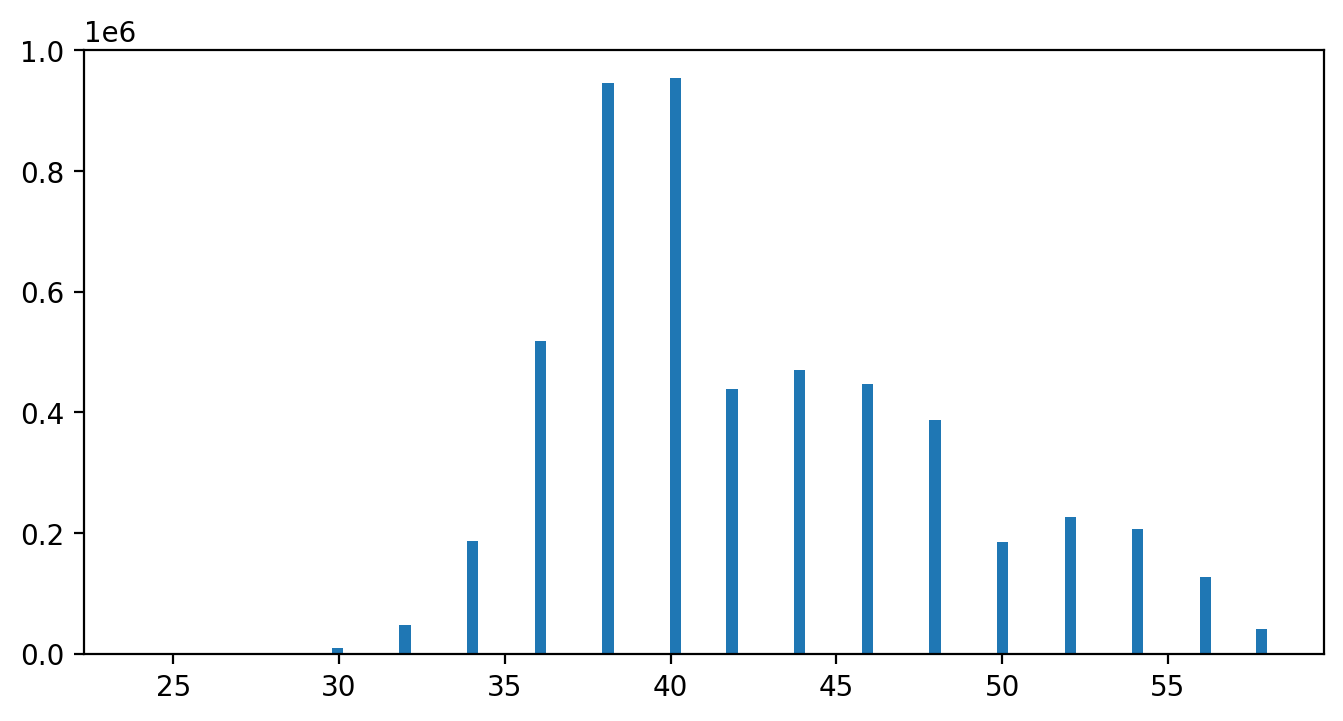

In [22]:
plt.hist(d.depths.flatten(),100)
plt.show()

In [23]:
d.freqs.shape

(1, 5, 1037437)

How many windows and what's the mean and median number of loci per window?

In [24]:
nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

6426
6429
mean number of loci: 161.20034219940894
median number of loci: 156.0


In [25]:
nloci

array([192,  58, 269, ..., 118,  72,  74])

In [26]:
#gw_covs = d.calc_cov(use_masked=True, standardize=True)
gw_covs = d.calc_cov()

In [27]:
gw_covs.shape

(4, 4)

<ipython-input-28-81cb7ab2e0aa>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sample_names)
<ipython-input-28-81cb7ab2e0aa>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sample_names)


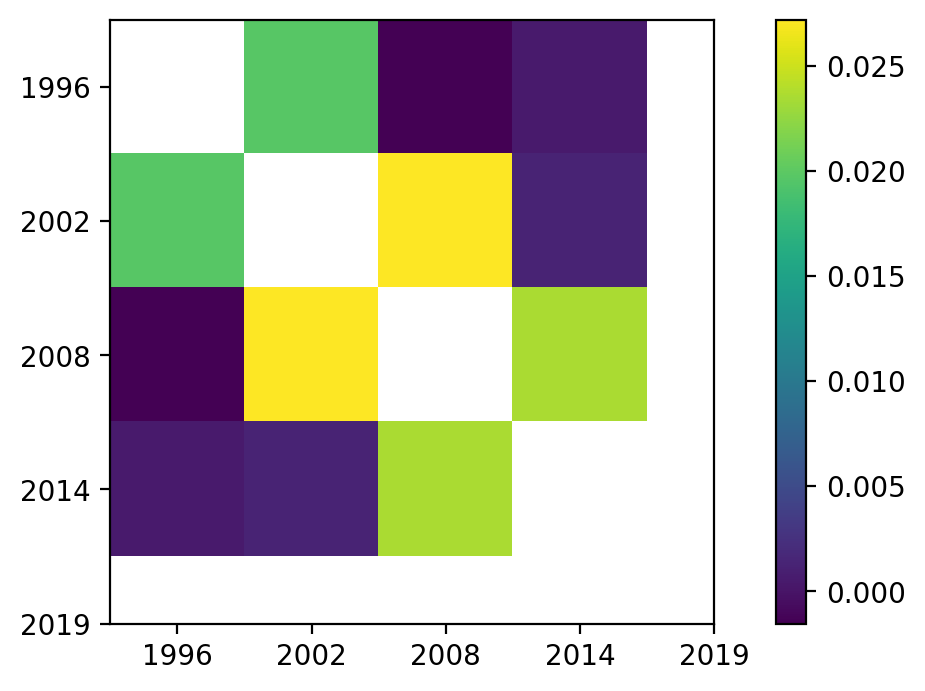

In [28]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['1996','2002','2008','2014','2019' ]
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(sample_names)))
#plt.savefig('/users/r/b/rbrennan/tonsa_genomics/figures/covariance_heatmap.pdf')

plt.show()

In [ ]:
#bootstrap covariance matrix
from tqdm import tqdm
from tqdm import tnrange
# need to use CI method "standard" to deal with bias in the bootstrap
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=None,
                              average_replicates=False, use_masked=True, ci_method="standard")

## Replicate Covariance Analysis

In [138]:
#gw_covs = d.calc_cov(use_masked=True, standardize=True)
gw_covs = d.calc_cov()

ValueError: negative dimensions are not allowed

In [139]:
def correct_dimensions(freqs, depths=None, diploids=None):
    # pad on an extra dimensions for 1-replicate designs
    if freqs.ndim == 2:
        freqs = freqs[np.newaxis, ...]
    if depths is not None:
        if depths.ndim == 2:
            depths = depths[np.newaxis, ...]
        assert(freqs.shape == depths.shape)

    R, ntimepoints, L = freqs.shape
    if diploids is not None:
        depth_is_single_int = diploids.size == 1
        depth_is_valid_vector = diploids.ndim == 2 and diploids.shape == (R, ntimepoints)
        depth_is_valid_array = diploids.ndim == 3 and diploids.shape == (R, ntimepoints, 1)
        if not (depth_is_single_int or depth_is_valid_vector or depth_is_valid_array):
            msg = ("diploids must be an integer or a matrix of shape "
                   f"nreplicates x ntimepoints ({R} x {ntimepoints})")
            raise ValueError(msg)
    return freqs, depths, diploids



In [140]:
depths=None
diploids=None
freqs, depths, diploids = correct_dimensions(d.freqs, depths, diploids)

In [141]:
def calc_deltas(freqs):
    """
    Calculates the deltas matrix, which is the frequency matrix where
    entry out[n] = x[n+1] - x[n]. This takes a R x T x L frequency array.
    """
    if freqs.ndim == 2:
        return np.diff(freqs, axis=0)
    elif freqs.ndim == 3:
        return np.diff(freqs, axis=1)
    else:
        raise ValueError("eqs.ndim must be eitehr 2 or 3")
        
deltas = calc_deltas(freqs)

In [142]:
def calc_hets(freqs, depths=None, diploids=None, bias=False, warn=False):
    R, T, L = freqs.shape
    if depths is not None:
        assert(freqs.shape == depths.shape)
    het = 2*freqs*(1-freqs)
    warn_type = 'ignore' if not warn else 'warn'
    with np.errstate(divide=warn_type, invalid=warn_type):
        if not bias:
            if depths is not None:
                het *= depths / (depths-1)
            if diploids is not None:
                het *= 2*diploids / (2*diploids - 1)
    return het


In [143]:
deltas

array([], shape=(5, 0, 499929), dtype=float64)

In [144]:
R, T, L = deltas.shape
deltas.shape

(5, 0, 499929)

In [145]:
def replicate_average_het_matrix(hets, R, T, L):
    """
    Create the heterozygosity denominator for the temporal-replicate
    variance covariance matrix.
    Create the heterozygosity denominator, which is of block form.
    Each block is a replicate. Each element is,
    (p_{A, min(t,s)}(1-p_{A, min(t,s)}) +
         p_{B, min(t,s)}(1-p_{B, min(t,s)})) / 2
    For temporal block covariance matrices (those along the diagonal), this is
    the same as the usual p_min(t,s) (1 - p_min(t,s)). For replicate blocks,
    we average the two initial frequencies.
    """
    assert(hets.shape == (R, T+1))
    # Create the heterozygosity denominator, which is of block form.
    # Each block is a replicate. Each element is,
    # (p_{A, min(t,s)}(1-p_{A, min(t,s)}) +
    #      p_{B, min(t,s)}(1-p_{B, min(t,s)})) / 2
    # for each replicate. We use some numpy tricks here.
    time_indices = np.arange(0, T)
    # this is the T x T matrix of min(s,t):
    min_t_s = np.minimum.outer(time_indices, time_indices)
    # next, we make the min(t,s) matrix of indices for each of the
    # replicate submatrices of the block matrix. There are R x R
    # block matrices, each block submatrix is T x T. This makes R x R
    # min(t,s) matrices to be used for indices:
    min_t_s_block = np.tile(min_t_s, (R, R))
    # now, we build indices for row/col for block matrices
    # which are used to index the heterozygosity denominators for
    # the replicated that are two be averaged:
    row_bm, col_bm = replicate_block_matrix_indices(R, T)
    # use indexing vectors to get heterozygosities
    A = hets[row_bm.ravel(), min_t_s_block.ravel()]
    B = hets[col_bm.ravel(), min_t_s_block.ravel()]
    avehet_min = (A + B).reshape((R*T, R*T)) / 2
    return avehet_min


def temporal_block_matrix_indices(R, T):
    """
    Return the indices of times t, s in each block matrix, where there are
    R x R block matrices (one for each replicate), and each block matrix is
    a covariance matrix of rows t, columns s timediffs.
    """
    row, col = replicate_block_matrix_indices(T, 1)
    rows = np.tile(row, (R, R))
    cols = np.tile(col, (R, R))
    return rows, cols

def replicate_block_matrix_indices(R, T):
    """
    Build block matrices of row and colum indices indicating the *replicate*.
    Each block matrix is (R x T) x (R x T), with each block being T x T.
    The structure is
    [[ A/A  A/A  A/C ]
     [ B/A  B/B  B/C ]
     [ C/A  C/B  C/C ]]
    with X/Y indicating replicate X, replicate Y blocks. The two matrices
    returned are rows (all the X values) and cols (all y values).
    """
    row_bm = np.vstack([np.full((T, R*T), i) for i in range(R)])
    col_bm = row_bm.T
    return (row_bm, col_bm)

def stack_replicate_covariances(covmat, R, T, stack=True, return_tuple=False,
                                upper_only=True, return_labels=False,
                                samples=None):
    """
    Upper only now.
    If stack=True, the last dimension is the number of replicates, and the
    first two dimensions are T, and T (for the covariance matrix).
    For easier printing, you probably want to transpose the results of this
    function when stack=True.
    """
    layers = []
    labels = []
    if return_labels:
        assert(samples is not None)
        labmat = cov_labels(R, T, samples)
    rows, cols = replicate_block_matrix_indices(R, T)
    for i in np.arange(R):
        for j in np.arange(R):
            if i == j:
                # ignore temporal covs
                continue
            if upper_only and i < j:
                continue
            this_block_matrix = np.logical_and(rows == i, cols == j)
            block = covmat[this_block_matrix].reshape(T, T)
            if return_labels:
                label_block = labmat[this_block_matrix].reshape(T, T)
            if stack:
                layers.append(block)
            else:
                if return_tuple:
                    # store i, j
                    layers.append((i, j, block))
                else:
                    layers.append(block)
            if return_labels:
                labels.append(label_block)
    if stack:
        if not return_labels:
            return np.stack(layers).T
        return np.stack(layers).T, np.stack(labels).T
    if not return_labels:
        return layers
    else:
        return layers, labels

hets = calc_hets(freqs, depths=depths, diploids=diploids)
mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
het_denom = replicate_average_het_matrix(mean_hets, R, T, L) / 2.

In [146]:
from cvtk.utils import flatten_matrix, view_along_axis

deltas = flatten_matrix(deltas, R, T, L)

In [147]:
#assert(deltas.ndim == 2)
deltas

array([], shape=(0, 499929), dtype=float64)